# Fit the optical spectrum of IRAS F07546+3928
* Check [astropy.modelling](https://docs.astropy.org/en/latest/modeling/index.html) for more introduction
* SAGAN adopts the frame work of astropy.modelling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from astropy.modeling import models, fitting
import sagan


import matplotlib as mpl
mpl.rc("xtick", direction="in", labelsize=16)
mpl.rc("ytick", direction="in", labelsize=16)
mpl.rc("xtick.major", width=1., size=8)
mpl.rc("ytick.major", width=1., size=8)
mpl.rc("xtick.minor", width=1., size=5)
mpl.rc("ytick.minor", width=1., size=5)

# automatic reload the modules
%load_ext autoreload
%autoreload 2

ls_km = 2.99792e5 # km/s

/Users/shangguan/Softwares/my_module/SAGAN/sagan/stellar_continuum.py:43: RuntimeWarning: invalid value encountered in log
  logf_star_A0V = np.interp(logw_even_kpa, logw_star, np.log(flux_A0V))


### Read data and correct the Milky Way extinction
* Data from [here](http://physics.uwyo.edu/agn/agnsed/agnsed.html)
* Check [here](https://extinction.readthedocs.io/en/latest/) for the doc of `extinction`
* Find the V band attenuation from https://ned.ipac.caltech.edu/ -- FOREGROUND GALACTIC EXTINCTION

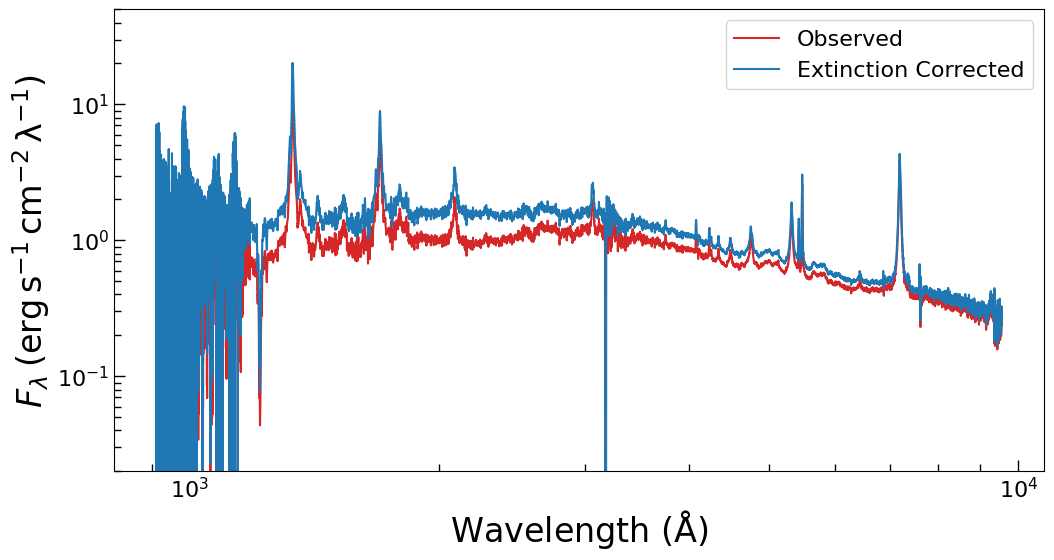

In [2]:
datapath = 'data'
hdul = fits.open(f'{datapath}/ir07546sed.fits')
header = hdul[0].header
flux = hdul[0].data * 1e14

w0 = header['CRVAL1']
dw = header['CD1_1']
wave = w0 + dw*np.arange(flux.size)

# Find the V band attenuation from https://ned.ipac.caltech.edu/ -- FOREGROUND GALACTIC EXTINCTION
from extinction import ccm89, remove

A_V = 0.176
flux_dred = remove(ccm89(wave, A_V, r_v=3.1, unit='aa'), flux)

fig, ax = plt.subplots(figsize=(12, 6))
ax.step(wave, flux, label='Observed', c='C3')
ax.step(wave, flux_dred, label='Extinction Corrected', c='C0')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.legend(fontsize=16)
ax.set_ylim(0.02, 50)
ax.minorticks_on()
plt.show()

### Cut the useful data
* First move to the rest frame
* Cut the wavelength range following Kuhn et al. (2024)

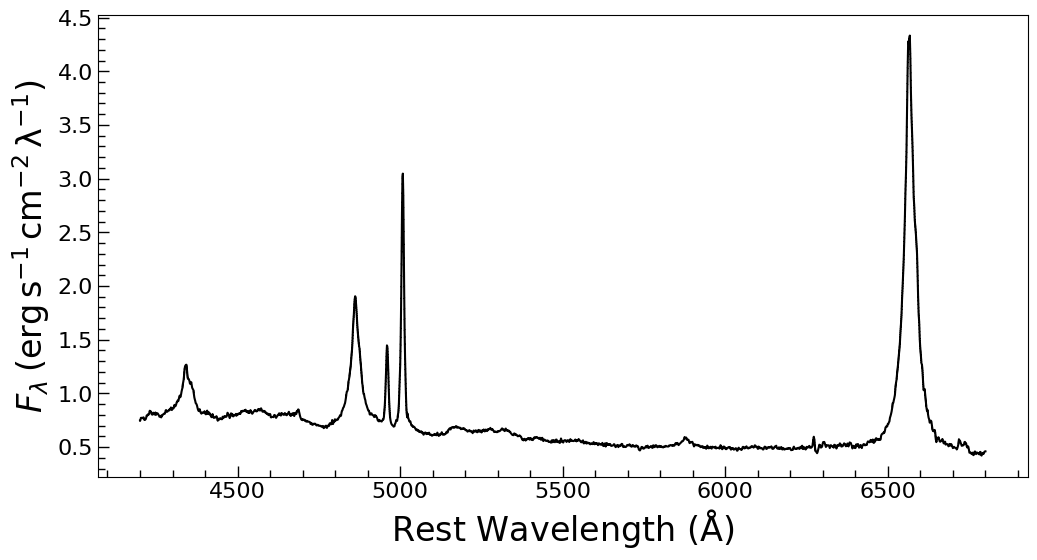

In [3]:
zred = 0.0953

fig, ax = plt.subplots(figsize=(12, 6))
wmin, wmax = 4200, 6800
wave_rst = wave / (1 + zred)
fltr = (wave_rst > wmin) & (wave_rst < wmax)
wave_use = wave_rst[fltr]
flux_use = flux_dred[fltr]

ax.step(wave_use, flux_use, color='k')
ax.set_xlabel(r'Rest Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.minorticks_on()
plt.show()

### Fit spectrum
* Check the emission lines here: http://astronomy.nmsu.edu/drewski/tableofemissionlines.html
* Tie all the narrow lines to [O III] $\lambda\lambda$ 4959,5007 doublet
* Iterate many times until you find a good result

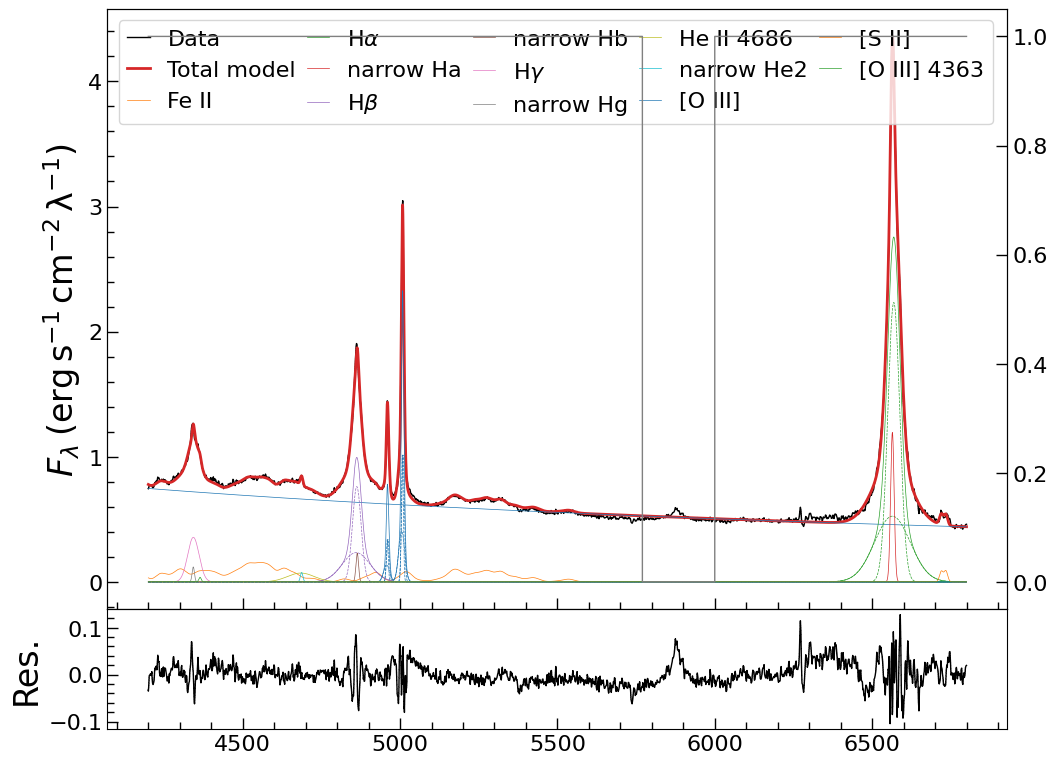

<PowerLaw1D(amplitude=0.55521421, x_0=5500., alpha=1.09726626)>
<IronTemplate(amplitude=0.21129694, stddev=1136.7605573, z=0., name='Fe II')>
<Line_MultiGauss(amp_c=2.23308468, dv_c=276.28767605, sigma_c=876.33548824, wavec=6562.819, amp_w0=0.23511398, dv_w0=-204.49362685, sigma_w0=2581.66782047, name='H$\\alpha$')>
<Line_Gaussian(amplitude=1.1946392, dv=73.35851102, sigma=256.74987319, wavec=6562.819, name='narrow Ha')>
<Line_MultiGauss(amp_c=0.761432, dv_c=-17.31094031, sigma_c=846.56133517, wavec=4862.721, amp_w0=0.30707149, dv_w0=-123.76122749, sigma_w0=2708.83247688, name='H$\\beta$')>
<Line_Gaussian(amplitude=0.23031392, dv=73.35851102, sigma=256.74987319, wavec=4862.721, name='narrow Hb')>
<Line_MultiGauss(amp_c=0.35607228, dv_c=94.18020471, sigma_c=1253.13303379, wavec=4341.785, name='H$\\gamma$')>
<Line_Gaussian(amplitude=0.1193125, dv=73.35851102, sigma=256.74987319, wavec=4341.785, name='narrow Hg')>
<Line_MultiGauss(amp_c=0.07053927, dv_c=-83.31323056, sigma_c=2727.12837557

In [4]:
wave_dict = sagan.utils.line_wave_dict
label_dict = sagan.utils.line_label_dict

pl = models.PowerLaw1D(amplitude=0.55, x_0=5500, alpha=1.0, fixed={'x_0': True})
iron = sagan.IronTemplate(amplitude=0.2, stddev=900, z=0, name='Fe II')

bounds = {'sigma_w0': (100, 4000)}
#b_ha = sagan.Line_MultiGauss(n_components=1, amp_c=2.22, dv_c=300, sigma_c=830, 
#                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'])
b_ha = sagan.Line_MultiGauss(n_components=2, amp_c=2.22, dv_c=280, sigma_c=830, 
                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'],
                             amp_w0=0.26, dv_w0=-185, sigma_w0=2400)

# It took me quite some time to adjust the initial guess for the Hbeta line
# so that the best-fit broad wing is not too broad and take the [O III] wings

#b_hb = sagan.Line_MultiGauss(n_components=1, amp_c=0.8, dv_c=-28, sigma_c=1000, 
#                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'])
b_hb = sagan.Line_MultiGauss(n_components=2, amp_c=0.8, dv_c=-17, sigma_c=850, 
                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'],
                             amp_w0=0.3, dv_w0=-120, sigma_w0=2700, bounds=bounds)
b_hg = sagan.Line_MultiGauss(n_components=1, amp_c=0.4, dv_c=80, sigma_c=1200, 
                             wavec=wave_dict['Hgamma'], name=label_dict['Hgamma'])

bounds = {'sigma_c': (100, 4000), 'dv_c': (-500, 500)}
b_he2 = sagan.Line_MultiGauss(n_components=1, amp_c=0.06, dv_c=85, sigma_c=2300, 
                              wavec=wave_dict['HeII_4686'], name=label_dict['HeII_4686'], 
                              bounds=bounds)
#b_he1 = sagan.Line_MultiGauss(n_components=1, amp_c=0.1, dv_c=0, sigma_c=1000, wavec=5875.624, name='He I 5876')  # Masked

#line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=1.8, amp_c1=0.6, dv_c=-43, sigma_c=250, 
#                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
#                                        amp_w0=0.35, dv_w0=-280, sigma_w0=340)
line_o3 = sagan.Line_MultiGauss_doublet(n_components=3, amp_c0=1.7, amp_c1=0.6, dv_c=-43, sigma_c=250, 
                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
                                        amp_w0=0.35, dv_w0=-280, sigma_w0=340, amp_w1=0.05, dv_w1=500, sigma_w1=1000)
line_s2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.1, amp_c1=0.1,
                                        wavec0=wave_dict['SII_6718'], wavec1=wave_dict['SII_6733'], name='[S II]')

# Usually we need [N II] 6548, 6583, but I cannot get a non-zero value for this doublet for this target
#line_n2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=1, amp_c1=0.3, dv_c=-20, sigma_c=200,
#                                        wavec0=wave_dict['NII_6548'], wavec1=wave_dict['NII_6583'], name='[N II]')

n_ha = sagan.Line_Gaussian(amplitude=1.1, wavec=wave_dict['Halpha'], name=f'narrow Ha')
n_hb = sagan.Line_Gaussian(amplitude=0.4, wavec=wave_dict['Hbeta'], name=f'narrow Hb')
n_hg = sagan.Line_Gaussian(amplitude=0.12, wavec=wave_dict['Hgamma'], name=f'narrow Hg')
n_he2 = sagan.Line_Gaussian(amplitude=0.08, wavec=wave_dict['HeII_4686'], name=f'narrow He2')
n_o3_4363 = sagan.Line_Gaussian(amplitude=0.05, wavec=wave_dict['OIII_4363'], name=f'[O III] 4363')

line_ha  =  b_ha + n_ha
line_hb  =  b_hb + n_hb
line_hg  =  b_hg + n_hg
line_he2 =  b_he2 + n_he2
#line_he1 =  b_he1  # Masked

m_init = pl + iron + line_ha + line_hb + line_hg + line_he2 + line_o3 + line_s2 + n_o3_4363

# Tie the line ratio of [O III] 5007/4959 to 2.98
def tie_o3(model):
    return model['[O III]'].amp_c0 / 2.98
line_o3.amp_c1.tied = tie_o3

#def tie_n2(model):
#    return model['[N II]'].amp_c0 / 2.96
#line_n2.amp_c1.tied = tie_n2

# Tie
def tie_narrow_sigma(model):
    return model['[O III]'].sigma_c

def tie_narrow_dv(model):
    return model['[O III]'].dv_c

line_s2.sigma_c.tied = tie_narrow_sigma
line_s2.dv_c.tied = tie_narrow_dv
#line_n2.sigma_c.tied = tie_narrow_sigma
#line_n2.dv_c.tied = tie_narrow_dv

for line in [n_ha, n_hb, n_hg, n_he2, n_o3_4363]:
    line.sigma.tied = tie_narrow_sigma
    line.dv.tied = tie_narrow_dv

fitter = fitting.LevMarLSQFitter()

weights = np.ones_like(flux_use)
fltr = (wave_use > 5770) & (wave_use < 6000)
weights[fltr] = 0.0
m_fit = fitter(m_init, wave_use, flux_use, weights=weights, maxiter=10000)  # Important to set a large maxiter!

ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit, weight=weights)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
plt.show()

for m in m_fit:
    print(m.__repr__())

### Multiply a polynomial to consider the instrument and local extinction
* Usually a low-order polynomial is enough
* Be careful not to create artificial wiggly continuum

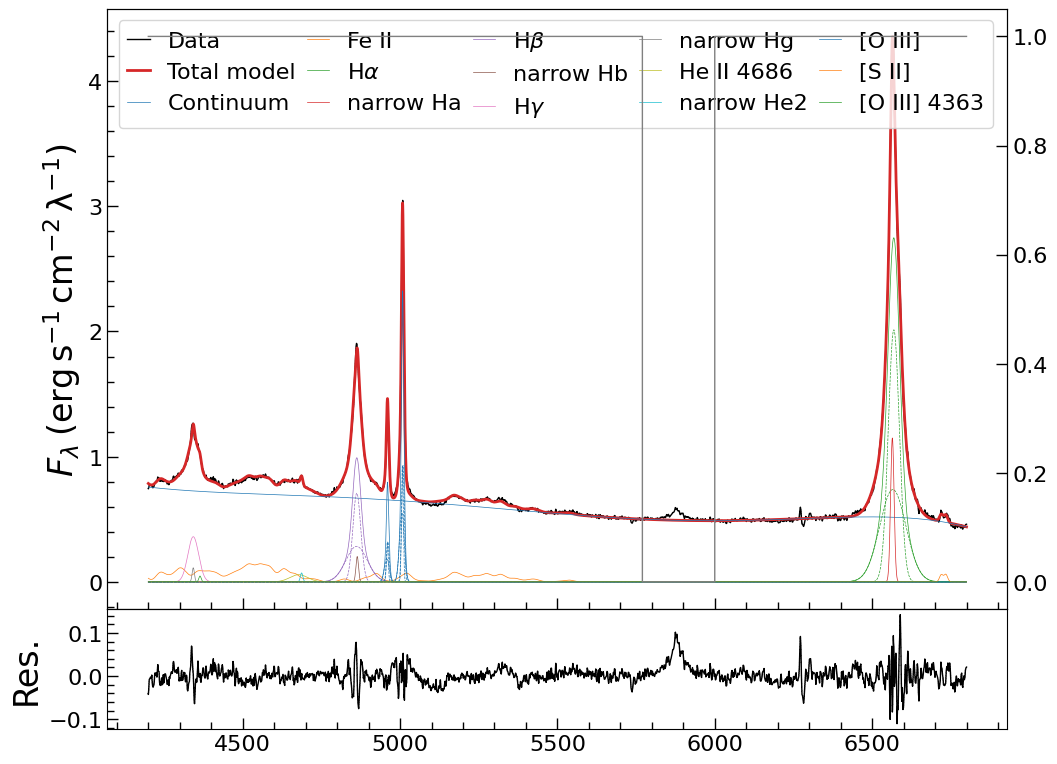

<PowerLaw1D(amplitude=10.68401093, x_0=5500., alpha=-0.88842213, name='Continuum')>
<IronTemplate(amplitude=2.4838394, stddev=953.20699512, z=0., name='Fe II')>
<Line_MultiGauss(amp_c=48.81632504, dv_c=287.19392988, sigma_c=808.11713869, wavec=6562.819, amp_w0=0.36595821, dv_w0=-126.50376959, sigma_w0=1904.1975359, name='H$\\alpha$')>
<Line_Gaussian(amplitude=27.81827221, dv=69.61426811, sigma=253.78639073, wavec=6562.819, name='narrow Ha')>
<Line_MultiGauss(amp_c=10.13185735, dv_c=-13.14971832, sigma_c=774.95904422, wavec=4862.721, amp_w0=0.40070714, dv_w0=-15.87306647, sigma_w0=2094.48070745, name='H$\\beta$')>
<Line_Gaussian(amplitude=2.8984606, dv=69.61426811, sigma=253.78639073, wavec=4862.721, name='narrow Hb')>
<Line_MultiGauss(amp_c=4.30295106, dv_c=81.52961987, sigma_c=1185.5279414, wavec=4341.785, name='H$\\gamma$')>
<Line_Gaussian(amplitude=1.34142379, dv=69.61426811, sigma=253.78639073, wavec=4341.785, name='narrow Hg')>
<Line_MultiGauss(amp_c=0.77009125, dv_c=-500., sigma_

In [5]:
poly = models.Polynomial1D(degree=5, name='multi')  # The name must be `multi`; no more than 5th order
pl = models.PowerLaw1D(amplitude=0.55, x_0=5500, alpha=1.0, fixed={'x_0': True}, name='Continuum')
iron = sagan.IronTemplate(amplitude=0.2, stddev=900, z=0, name='Fe II')

bounds = {'sigma_w0': (100, 4000)}
#b_ha = sagan.Line_MultiGauss(n_components=1, amp_c=2.22, dv_c=300, sigma_c=830, 
#                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'])
b_ha = sagan.Line_MultiGauss(n_components=2, amp_c=2.22, dv_c=280, sigma_c=830, 
                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'],
                             amp_w0=0.26, dv_w0=-185, sigma_w0=2400)

#b_hb = sagan.Line_MultiGauss(n_components=1, amp_c=0.8, dv_c=-28, sigma_c=1000, 
#                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'])
b_hb = sagan.Line_MultiGauss(n_components=2, amp_c=0.8, dv_c=-17, sigma_c=850, 
                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'],
                             amp_w0=0.3, dv_w0=-120, sigma_w0=2700, bounds=bounds)
b_hg = sagan.Line_MultiGauss(n_components=1, amp_c=0.4, dv_c=80, sigma_c=1200, 
                             wavec=wave_dict['Hgamma'], name=label_dict['Hgamma'])

bounds = {'sigma_c': (100, 4000), 'dv_c': (-500, 500)}
b_he2 = sagan.Line_MultiGauss(n_components=1, amp_c=0.06, dv_c=85, sigma_c=2300, 
                              wavec=wave_dict['HeII_4686'], name=label_dict['HeII_4686'], 
                              bounds=bounds)
#b_he1 = sagan.Line_MultiGauss(n_components=1, amp_c=0.1, dv_c=0, sigma_c=1000, wavec=5875.624, name='He I 5876')  # Masked

#line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=1.8, amp_c1=0.6, dv_c=-43, sigma_c=250, 
#                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
#                                        amp_w0=0.35, dv_w0=-280, sigma_w0=340)
line_o3 = sagan.Line_MultiGauss_doublet(n_components=3, amp_c0=1.7, amp_c1=0.6, dv_c=-43, sigma_c=250, 
                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
                                        amp_w0=0.35, dv_w0=-280, sigma_w0=340, amp_w1=0.05, dv_w1=500, sigma_w1=1000)
line_s2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.1, amp_c1=0.1,
                                        wavec0=wave_dict['SII_6718'], wavec1=wave_dict['SII_6733'], name='[S II]')

# Usually we need [N II] 6548, 6583, but I cannot get a non-zero value for this doublet for this target
#line_n2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=1, amp_c1=0.3, dv_c=-20, sigma_c=200,
#                                        wavec0=wave_dict['NII_6548'], wavec1=wave_dict['NII_6583'], name='[N II]')

n_ha = sagan.Line_Gaussian(amplitude=1.1, wavec=wave_dict['Halpha'], name=f'narrow Ha')
n_hb = sagan.Line_Gaussian(amplitude=0.4, wavec=wave_dict['Hbeta'], name=f'narrow Hb')
n_hg = sagan.Line_Gaussian(amplitude=0.12, wavec=wave_dict['Hgamma'], name=f'narrow Hg')
n_he2 = sagan.Line_Gaussian(amplitude=0.08, wavec=wave_dict['HeII_4686'], name=f'narrow He2')
n_o3_4363 = sagan.Line_Gaussian(amplitude=0.05, wavec=wave_dict['OIII_4363'], name=f'[O III] 4363')

line_ha  =  b_ha + n_ha
line_hb  =  b_hb + n_hb
line_hg  =  b_hg + n_hg
line_he2 =  b_he2 + n_he2
#line_he1 =  b_he1  # Masked

m_init = (pl + iron + line_ha + line_hb + line_hg + line_he2 + line_o3 + line_s2 + n_o3_4363) * poly

# Tie the line ratio of [O III] 5007/4959 to 2.98
def tie_o3(model):
    return model['[O III]'].amp_c0 / 2.98
line_o3.amp_c1.tied = tie_o3

#def tie_n2(model):
#    return model['[N II]'].amp_c0 / 2.96
#line_n2.amp_c1.tied = tie_n2

# Tie
def tie_narrow_sigma(model):
    return model['[O III]'].sigma_c

def tie_narrow_dv(model):
    return model['[O III]'].dv_c

line_s2.sigma_c.tied = tie_narrow_sigma
line_s2.dv_c.tied = tie_narrow_dv
#line_n2.sigma_c.tied = tie_narrow_sigma
#line_n2.dv_c.tied = tie_narrow_dv

for line in [n_ha, n_hb, n_hg, n_he2, n_o3_4363]:
    line.sigma.tied = tie_narrow_sigma
    line.dv.tied = tie_narrow_dv

fitter = fitting.LevMarLSQFitter()

weights = np.ones_like(flux_use)
fltr = (wave_use > 5770) & (wave_use < 6000)
weights[fltr] = 0.0
m_fit = fitter(m_init, wave_use, flux_use, weights=weights, maxiter=10000)  # Important to set a large maxiter!

ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit, weight=weights)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
plt.show()

for m in m_fit:
    print(m.__repr__())

### Generate the normalized line profiles

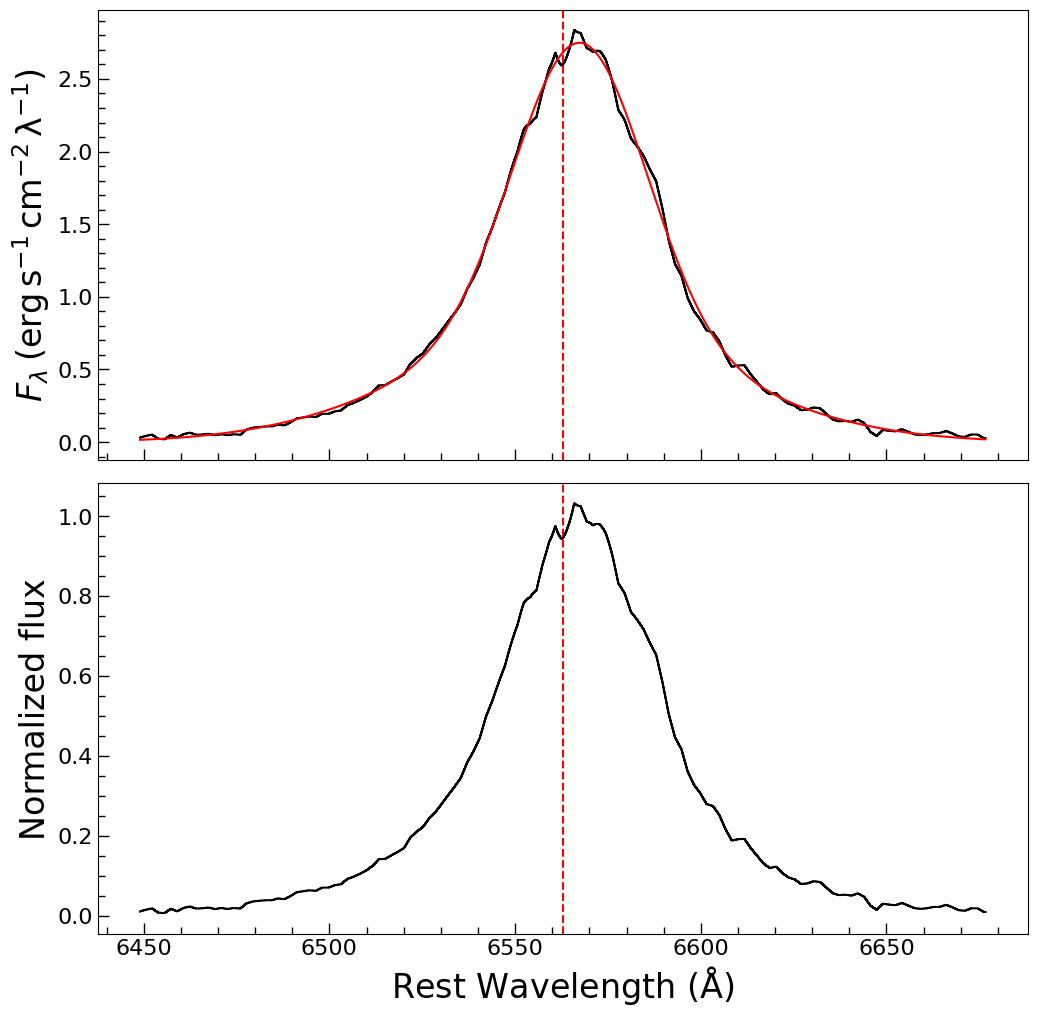

In [6]:
# H-alpha

m_multi = m_fit['multi'](wave_use)
m_halpha = m_fit[label_dict['Halpha']](wave_use) * m_multi
flux_halpha = flux_use.copy()

# Correct the wavelength so that the narrow lines have central velocity of zero
dv_sys = m_fit['[O III]'].dv_c.value
wave_corr = wave_use * (1 - dv_sys / ls_km)
velc = (wave_corr / wave_dict['Halpha'] - 1) * ls_km

# Cut the line profile to -5200 to 5200 km/s
fltr = (velc > -5200) & (velc < 5200)

for m in m_fit:
    if m.name in ['multi', label_dict['Halpha']]:
        continue

    flux_halpha -= m(wave_use) * m_multi

wave_ha = wave_corr[fltr]
flux_ha = flux_halpha[fltr]
model_ha = m_halpha[fltr]

flux_ha_norm = flux_ha / np.max(model_ha)
ferr_ha_norm = np.zeros_like(flux_ha_norm) # Please note that the error is missing for now!

fig, axs = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
fig.subplots_adjust(hspace=0.05)

ax = axs[0]
ax.step(wave_ha, flux_ha, color='k')
ax.plot(wave_ha, model_ha, color='r')
ax.axvline(wave_dict['Halpha'], ls='--', color='r')
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.minorticks_on()

ax = axs[1]
ax.step(wave_ha, flux_ha_norm, color='k')
ax.axvline(wave_dict['Halpha'], ls='--', color='r')
ax.set_xlabel(r'Rest Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.minorticks_on()
ax.set_ylabel('Normalized flux', fontsize=24)
plt.show()

data = np.array([wave_ha, flux_ha_norm, ferr_ha_norm]).T
#np.savetxt('data_ha.dat', data, fmt='%.6f')